In [2]:
import requests
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt
import os
from utils import *

page = 1
url = f"http://ocr.iguidevietnam.com/processes/41cbdc5f-c962-41bd-e792-08dc49b1ac23/items?status=done&page={page}&size=10"

response = requests.get(url)
response = response.json()
print(response['totalItems'])
# print(response)
annotation_data = []
if not os.path.exists('data'):
    os.mkdir('data')
if not os.path.exists('data/imgs'):
    os.mkdir('data/imgs')

for page in range (1, response['totalPages']+1):
# for page in range (1,2):
    url = f"http://ocr.iguidevietnam.com/processes/41cbdc5f-c962-41bd-e792-08dc49b1ac23/items?status=done&page={page}&size=10"
    response = requests.get(url)
    response = response.json()
    # print(response['totalItems'])
    for item in response['items']:
        img_response = requests.get(item['image'])
        nparr = np.fromstring(img_response.content, np.uint8)

        img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
        # img = Image.open(BytesIO(response.content))
        for box in item['result']['textboxes']:
            coordinates = [[c['x'], c['y']] for c in box["bndbox"]]
            if len(coordinates) != 4 or box['label'] == 'manufactured_country':
                continue
            h = np.sqrt((coordinates[0][0] - coordinates[1][0])**2 + (coordinates[0][1] - coordinates[1][1])**2)
            w = np.sqrt((coordinates[1][0] - coordinates[2][0])**2 + (coordinates[1][1] - coordinates[2][1])**2)
            homo, status = cv2.findHomography(np.array(coordinates), np.array([[0,0],[0,h],[w,h],[w,0]]))
            trans_img = cv2.warpPerspective(img, homo, (int(w),int(h)))
            file_name = add_to_end_of_filename(item['name'], box['label'])
            file_path = f'imgs/{file_name}'
            cv2.imwrite(f'data/{file_path}', trans_img)
            annotation_data.append(f"{file_path}\t{box['text']}\n")
            # visualize_opencv_image(trans_img)
            # print(box['text'])

import random
random.shuffle(annotation_data)
train_test_ratio = 0.7
index = round(len(annotation_data)*train_test_ratio)
print(index)

#write back the file
with open("data/train_annotation.txt","w") as f:
    f.writelines(annotation_data[:index])
with open("data/test_annotation.txt","w") as f:
    f.writelines(annotation_data[index:])

616


/tmp/ipykernel_12675/3742120535.py:30: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  nparr = np.fromstring(img_response.content, np.uint8)


3602


/tmp/ipykernel_321162/3099605166.py:21: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  nparr = np.fromstring(img_response.content, np.uint8)


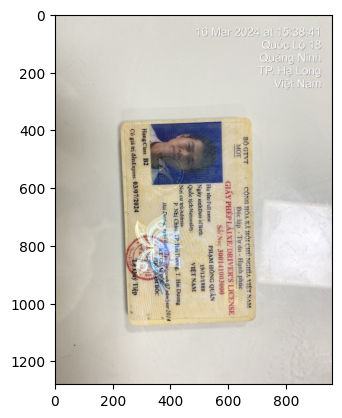

{'height': 761, 'width': 1210, 'homo': 'aaJJk310wT845xPQJdYAQKzyIgqWE4fAh1j/4kwSAMAbTLWiuSCnP9FyIwh1RJJAXhtfp97AIz/5rPCzbywDvwAAAAAAAPA/', 'width_ratio': 1.1552346570397112, 'height_ratio': 1.1552346570397112}
[[ 1.36367509e-01  2.10456431e+00 -7.38448262e+02]
 [-2.00893571e+00  4.51715480e-02  1.16911429e+03]
 [ 1.50706462e-04 -3.65707006e-05  1.00000000e+00]]


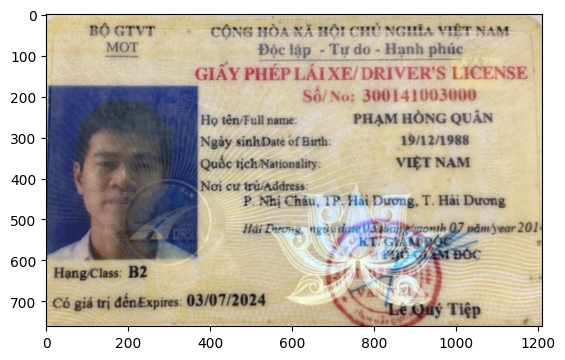

In [29]:
import requests
import requests
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt
import base64

# image_url = "http://ocr.iguidevietnam.com/files/20240321/3a08e810-52f0-49f2-a3ee-f0ca4d14b220.jpg"
image_url = "http://ocr.iguidevietnam.com/files/20240321/40100d90-c0aa-448d-ae14-272c6b20f728.jpg"

def visualize_opencv_image(img):
    import cv2
    import matplotlib.pyplot as plt

    image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.show()

img_response = requests.get(image_url)
nparr = np.fromstring(img_response.content, np.uint8)
img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
visualize_opencv_image(img)

# Get homograpy matrix
files = {"img": img_response.content}
host = "http://118.107.77.131:8008"
# host = "http://localhost:8000"
response = requests.post(f"{host}/get_homography?type=gplx", files=files, timeout=200)
first_homo = response.json()[0]
print(first_homo)
W = first_homo['width']
H = first_homo['height']
homo_str = first_homo['homo']
img_bytes = base64.b64decode(homo_str)
homo = np.frombuffer(img_bytes, np.float64).reshape((3,3))
print(homo)
resized_img = cv2.resize(img, (int(img.shape[1]/first_homo['width_ratio']), int(img.shape[0]/first_homo['height_ratio'])))
new_img = cv2.warpPerspective(resized_img, homo, (W,H))
visualize_opencv_image(new_img)

In [ ]:
!git clone https://github.com/hungpham13/ocr-training
%cd ocr-training
!pip install -q -r requirements.txt
from google.colab import drive
drive.mount('/content/drive')
!unzip -qq -r /content/drive/MyDrive/data.zip

# Train model



1.   Load your config
2.   Train model using your dataset above



Load the default config, we adopt VGG for image feature extraction

In [3]:
from vietocr.tool.config import Cfg
from vietocr.model.trainer import Trainer

# Change the config 

* *data_root*: the folder save your all images
* *train_annotation*: path to train annotation
* *valid_annotation*: path to valid annotation
* *print_every*: show train loss at every n steps
* *valid_every*: show validation loss at every n steps
* *iters*: number of iteration to train your model
* *export*: export weights to folder that you can use for inference
* *metrics*: number of sample in validation annotation you use for computing full_sequence_accuracy, for large dataset it will take too long, then you can reuduce this number


In [4]:
config = Cfg.load_config_from_name('vgg_transformer')

In [5]:

dataset_params = {
    'name':'gdk',
    'data_root':'./data/',
    'train_annotation':'train_annotation.txt',
    'valid_annotation':'test_annotation.txt'
}

params = {
         'print_every':200,
         'valid_every':15*200,
          'iters':20000,
          'checkpoint':'./checkpoint/transformerocr_checkpoint.pth',    
          'export':'./weights/transformerocr.pth',
          'metrics': 10000
         }

config['trainer'].update(params)
config['dataset'].update(dataset_params)
config['aug']['image_aug']= False
# config['device'] = 'cuda:0'
config['device'] = 'cpu'

you can change any of these params in this full list below

In [6]:
config

{'vocab': 'aAàÀảẢãÃáÁạẠăĂằẰẳẲẵẴắẮặẶâÂầẦẩẨẫẪấẤậẬbBcCdDđĐeEèÈẻẺẽẼéÉẹẸêÊềỀểỂễỄếẾệỆfFgGhHiIìÌỉỈĩĨíÍịỊjJkKlLmMnNoOòÒỏỎõÕóÓọỌôÔồỒổỔỗỖốỐộỘơƠờỜởỞỡỠớỚợỢpPqQrRsStTuUùÙủỦũŨúÚụỤưƯừỪửỬữỮứỨựỰvVwWxXyYỳỲỷỶỹỸýÝỵỴzZ0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ ',
 'device': 'cpu',
 'seq_modeling': 'transformer',
 'transformer': {'d_model': 256,
  'nhead': 8,
  'num_encoder_layers': 6,
  'num_decoder_layers': 6,
  'dim_feedforward': 2048,
  'max_seq_length': 1024,
  'pos_dropout': 0.1,
  'trans_dropout': 0.1},
 'optimizer': {'max_lr': 0.0003, 'pct_start': 0.1},
 'trainer': {'batch_size': 32,
  'print_every': 200,
  'valid_every': 3000,
  'iters': 20000,
  'export': './weights/transformerocr.pth',
  'checkpoint': './checkpoint/transformerocr_checkpoint.pth',
  'log': './train.log',
  'metrics': 10000},
 'dataset': {'name': 'gdk',
  'data_root': './data/',
  'train_annotation': 'train_annotation.txt',
  'valid_annotation': 'test_annotation.txt',
  'image_height': 32,
  'image_min_width': 32,
  'image_max_wi

You should train model from our pretrained 

In [11]:
trainer = Trainer(config, pretrained=True)

Model weight /tmp/vgg_transformer.pth exsits. Ignore download!


Create train_gdk:   0%|                                                    | 0/3602 [00:00<?, ?it/s]

not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)


Create train_gdk:  26%|██████████▏                             | 922/3602 [00:00<00:00, 4498.01it/s]

not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)


Create train_gdk:  52%|████████████████████▏                  | 1861/3602 [00:00<00:00, 4298.44it/s]

not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)


Create train_gdk:  77%|█████████████████████████████▉         | 2762/3602 [00:00<00:00, 4123.55it/s]

not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)


Create train_gdk: 100%|███████████████████████████████████████| 3602/3602 [00:00<00:00, 3892.30it/s]

not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
Remove 36 invalid images
Created dataset with 3565 samples



Create valid_gdk:  61%|████████████████████████▌               | 946/1544 [00:00<00:00, 4579.12it/s]

not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)


Create valid_gdk: 100%|███████████████████████████████████████| 1544/1544 [00:00<00:00, 4032.02it/s]

not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
Remove 13 invalid images
Created dataset with 1530 samples



valid_gdk build cluster: 100%|██████████████████████████████| 1530/1530 [00:00<00:00, 276392.67it/s]


Save model configuration for inference, load_config_from_file

In [12]:
trainer.config.save('config.yml')

Visualize your dataset to check data augmentation is appropriate

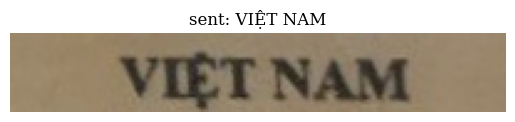

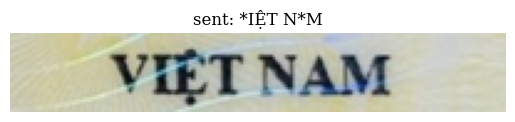

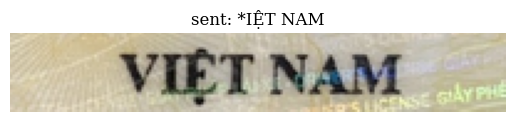

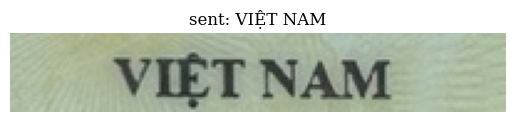

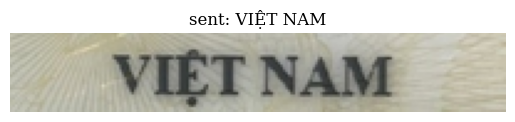

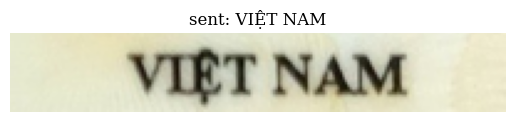

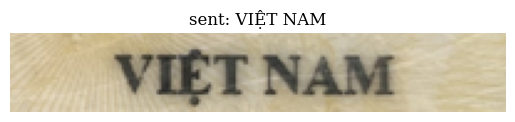

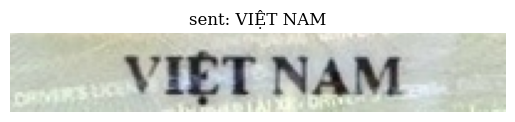

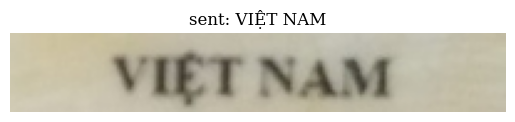

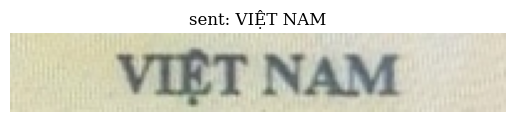

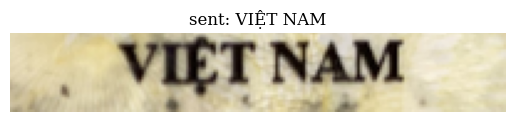

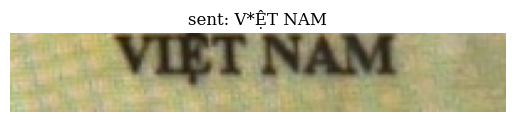

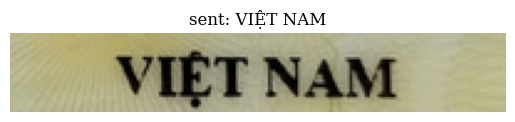

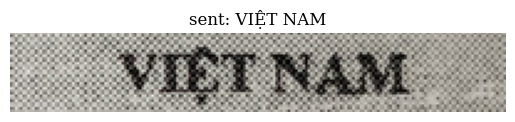

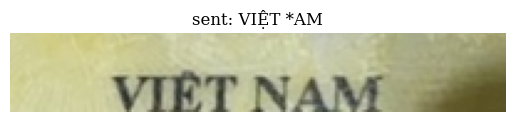

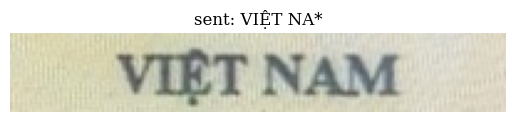

In [21]:
trainer.visualize_dataset()

Train now

In [49]:
trainer.train()

/home/hung/PycharmProjects/ocr-training/venv/lib/python3.10/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


KeyboardInterrupt: 

Visualize prediction from our trained model


In [ ]:
trainer.visualize_prediction()

Compute full seq accuracy for full valid dataset

In [ ]:
trainer.precision()